# 프로젝트 : 난 스케치를 할 테니 너는 채색을 하거라
**난 떡을 썰테니 너는 글을 쓰거라**

## 1. 데이터 준비하기
- **데이터 불러오기**
- **데이터 전처리**

## 2. 모델 설계하기

## 3. 모델 학습하기

## 4. 모델 학습 결과

In [1]:
import numpy
import tensorflow

print(numpy.__version__)
print(tensorflow.__version__)

1.21.4
2.6.0


- - -
### 데이터 준비하기
- **데이터 불러오기**

In [2]:
import os

data_path = os.getenv('HOME') + '/aiffel/EXPLORATION/dataset/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


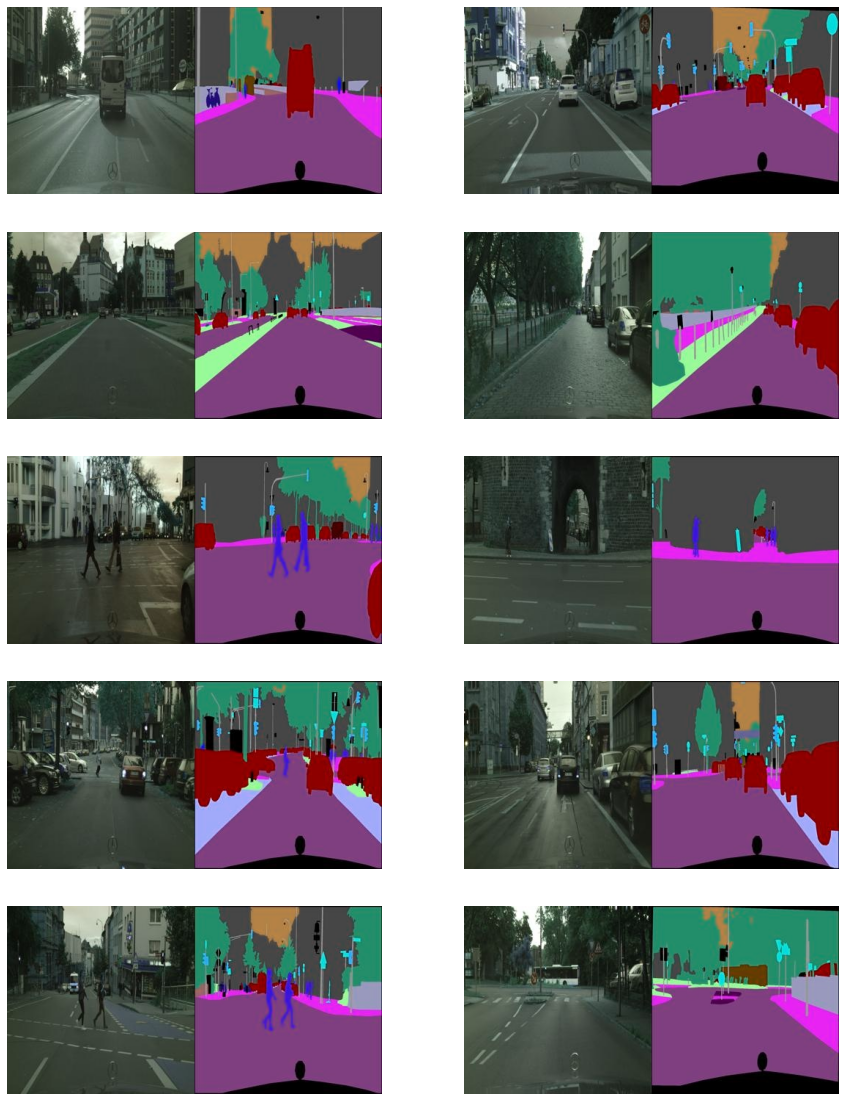

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 20))

for i in range(1, 11):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(5, 2, i)
    plt.imshow(img)
    plt.axis('off') # x, y 눈금 제거

도로 이미지 데이터셋을 불러옵니다.

실제 이미지와 의미 분할 세그멘테이션을 한 이미지가 있습니다.

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


256x256의 이미지를 옆으로 이어붙여서 256x512의 크기가 되겠습니다.

- - -
### 데이터 준비하기
- **데이터 전처리**

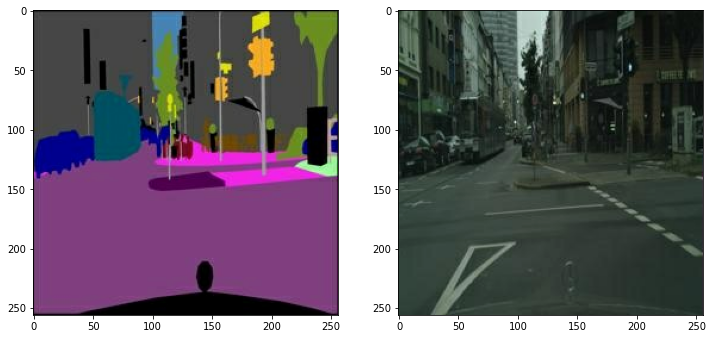

In [5]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x / 127.5) - 1

def denormalize(x):
    x = (x + 1) * 127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :]
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :]
    colored = tf.cast(colored, tf.float32)
    
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[0]
sketch, colored = load_img(f)

plt.figure(figsize=(12, 7))
plt.subplot(121); plt.imshow(denormalize(sketch))
plt.subplot(122); plt.imshow(denormalize(colored))
plt.show()

실제 이미지를 레이블로 두고 세그멘테이션 이미지를 실제 이미지처럼 채색해주는 모델을 만들어야 합니다.

In [6]:
from tensorflow import image

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    out = image.flip_left_right(stacked)
    out = image.random_crop(out, size=[192, 192, 6])
    out = tf.image.resize(out, [256, 256])
    
    return out[..., :3], out[..., 3:]

augmentation을 어떻게 할 것인가? 잠시 고민을 해본 결과

포켓몬 예제에서는 가로와 세로를 모두 뒤집었지만 제가 사용할 도로 이미지는 무작위가 아닌 확정적으로 가로만 뒤집어주겠습니다.

그리고 256x256의 이미지 내에서 무작위로 192x192만큼의 부분을 추출하고 다시 정사이즈로 업스케일링을 해서 데이터의 다양성을 추가했습니다.

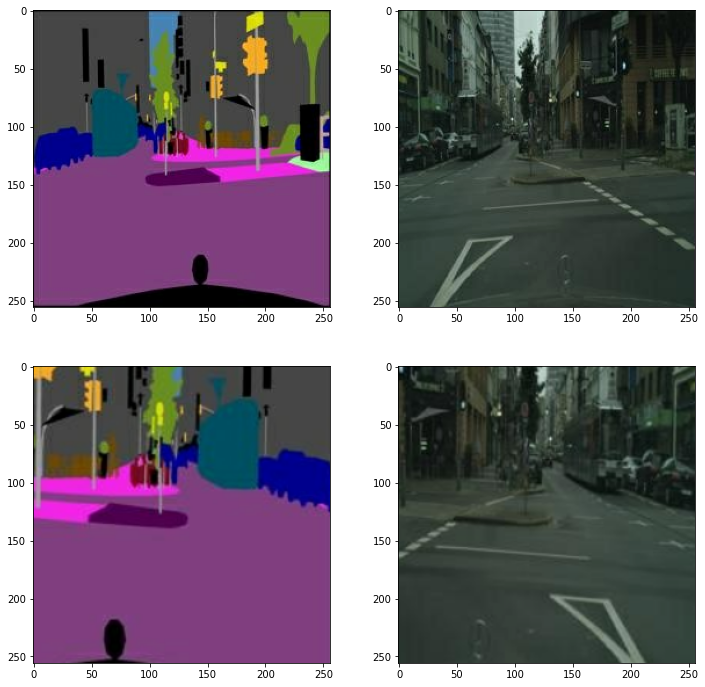

In [7]:
augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)

plt.figure(figsize=(12, 12))
plt.subplot(221); plt.imshow(denormalize(sketch))
plt.subplot(222); plt.imshow(denormalize(colored))
plt.subplot(223); plt.imshow(denormalize(augmented_sketch))
plt.subplot(224); plt.imshow(denormalize(augmented_colored))

제가 만든 augmentation를 적용하면 가로를 뒤집으면서 무작위로 전체 이미지의 192x192. 즉,

3/4 만큼만을 이미지로 사용하게 됩니다.

In [8]:
from tensorflow import data

def get_augmentation_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    
    return sketch, colored

dataset = data.Dataset.list_files(data_path + "*.jpg")
train_images = dataset.map(lambda x: load_img(x)).concatenate(dataset.map(get_augmentation_train))

len(train_images)

2000

그리고 원본 이미지와 augmentation을 한 이미지를 합쳐서

1000개의 데이터를 두 배로 늘려줬습니다.

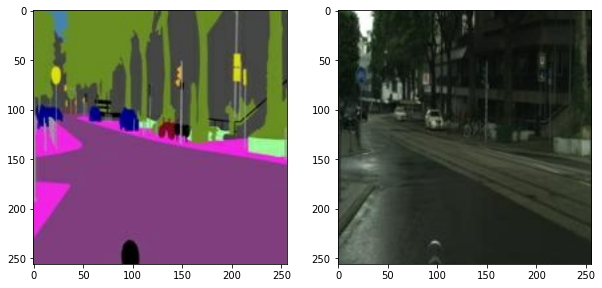

In [9]:
train_images = train_images.shuffle(2000).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10, 5))
plt.subplot(121); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(122); plt.imshow(colored[0].astype(np.uint8))

데이터셋을 섞어주면서 텐서플로우 배치사이즈 형태로 변환해줍니다.

확인용으로 0번째 데이터를 출력해보니 데이터와 레이블로 잘 나뉘었군요.

- - -
### 모델 설계하기

In [10]:
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.utils import plot_model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn
        self.conv = layers.Conv2D(n_filters, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
            
        return self.lrelu(x)

class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
            
        return self.relu(x)

반복문으로 레이어를 쌓을 수 있게 필터의 개수만 받으면 레이어를 출력해주도록 만든 인코더블록과 디코더블록입니다.

커널 사이즈와 스트라이드는 (4, 4), (2, 2) 고정으로, 레이어를 거치면 이미지의 크기가 두 배씩 커지도록 설계되었습니다.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

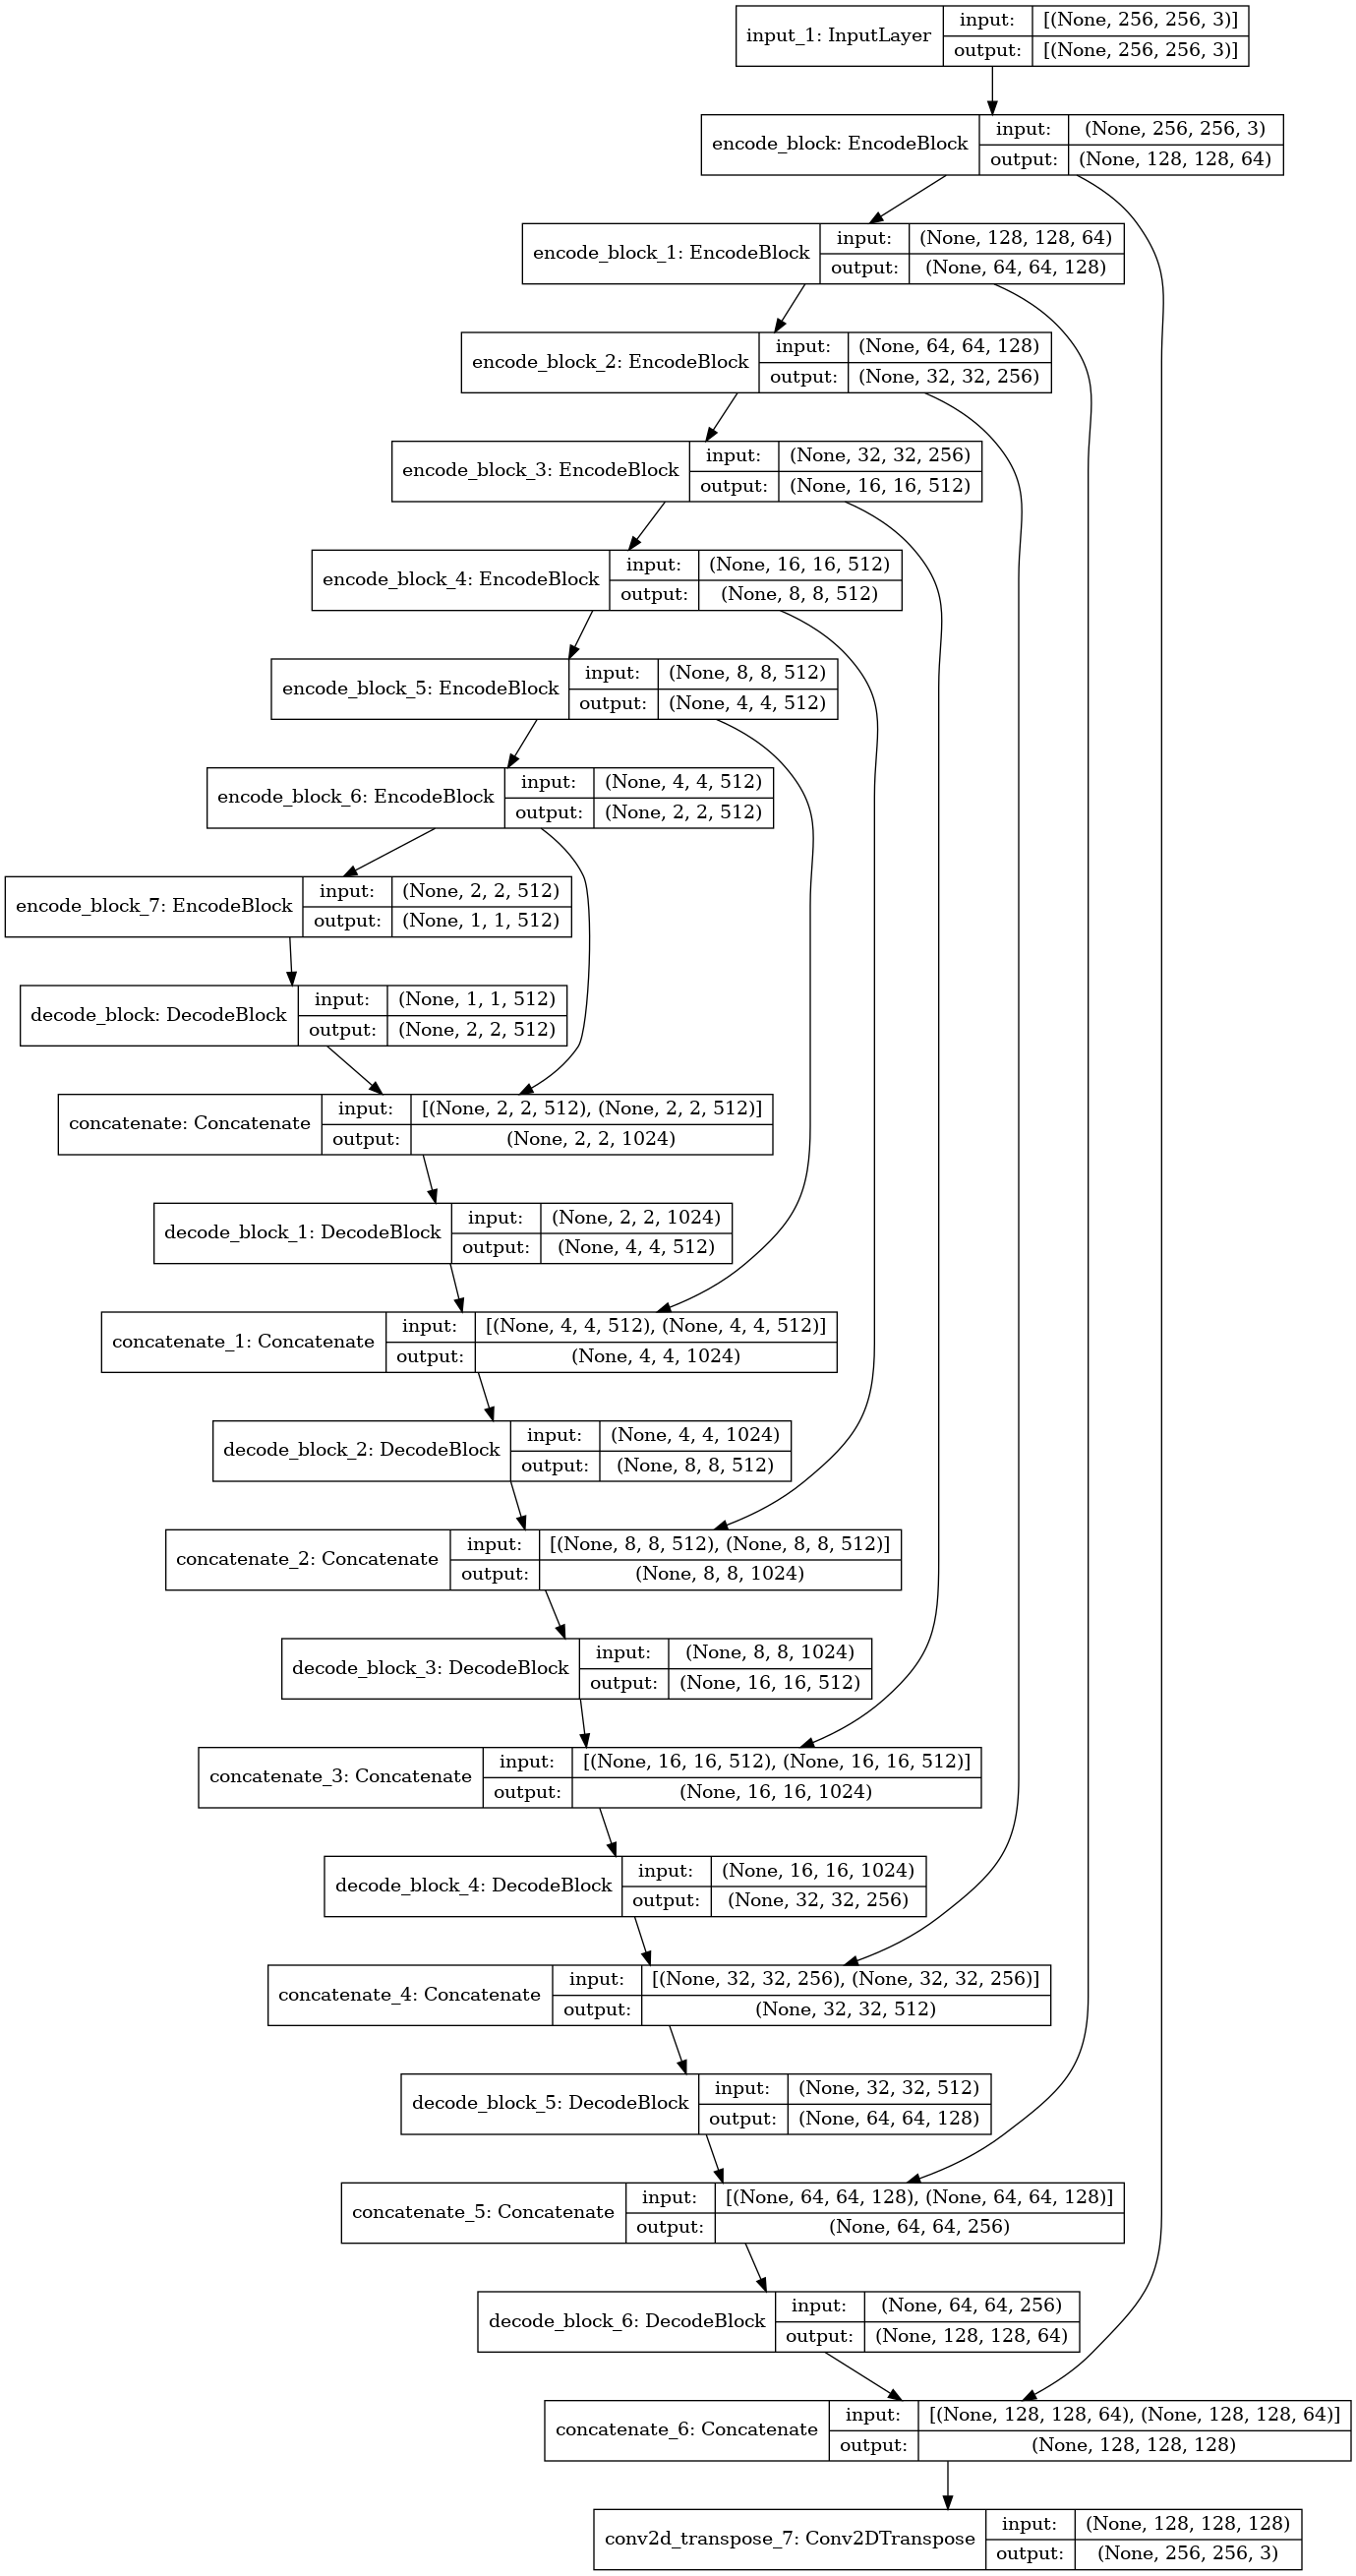

In [11]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64, 128, 256, 512, 512, 512, 512, 512]
        decode_filters = [512, 512, 512, 512, 256, 128, 64]
        
        self.encode_blocks = []
        
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
        
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        
        return x
    
    def get_summary(self, input_shape=(256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs))

UNet = UNetGenerator().get_summary()
UNet.summary()
plot_model(UNet, show_shapes=True)

앞서 만든 인코더블록과 디코더블록을 이용해 반복문으로 간편하게 레이어를 쌓은 것이 인상적입니다.

계속 보다보니 이해는 갔는데 뭐라 설명하진 못하겠네요.

인코더와 디코더를 합치지만 기존 모델과 다르게 *skip connection*을 사용한 **U-Net** 생성기 모델입니다.

RNN의 어텐션 레이어와 역할이 비슷합니다.

In [12]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
        
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x

판별기도 반복문으로 레이어를 쌓을 수 있게 블록을 준비했습니다.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

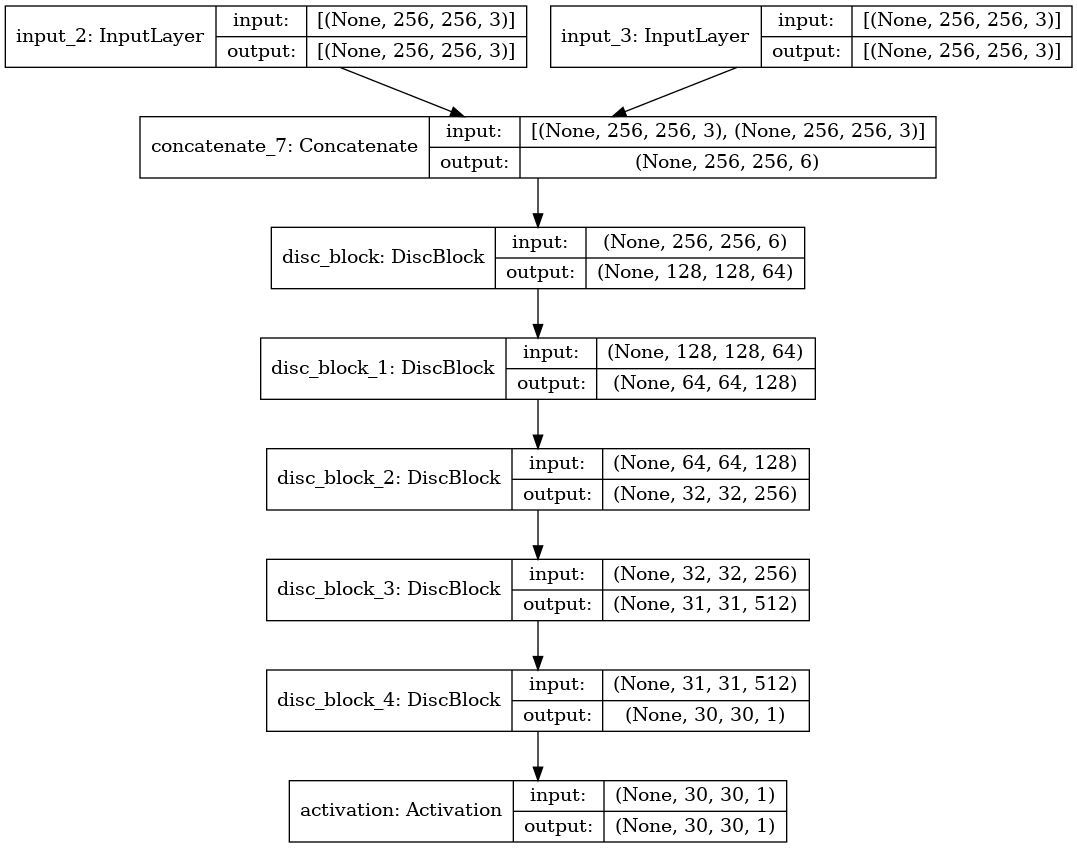

In [13]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256, 256, 3), y_shape=(256, 256, 3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y))

Disc = Discriminator().get_summary()
Disc.summary()
plot_model(Disc, show_shapes=True)

하지만 예제에 있는 그대로 쓰겠습니다...

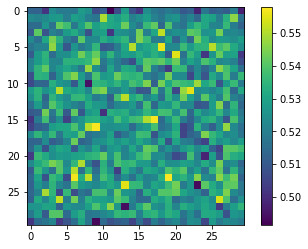

In [14]:
x = tf.random.normal([1, 256, 256, 3])
y = tf.random.uniform([1, 256, 256, 3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

판별기에 256x256의 이미지를 넣으면 30x30의 크기로 출력됩니다.

진짜 이미지와 가짜 이미지를 구별해서 loss를 구하기 위해 이미지의 특징만을 추출하려는 목적으로 볼 수 있겠습니다.

In [15]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

손실지표 함수입니다.

이 중 l1 loss는 판별기를 거치지 않고 실제 이미지와 가짜 이미지만으로 구하는 loss인데요.

단순히 실제 이미지와의 mae loss를 구하기 때문에 따지고보면 더 엄격하지만 유연성이 없어서 다양성은 없는 대신 디테일이 더 좋겠군요.

그냥 cGAN을 사용할 때보다 l1 loss를 같이 짬뽕해서 사용했을 때 더 좋은 이미지가 나온다고 합니다.

In [16]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

최적화 함수는 아담에 러닝레이트는 0.0002를 줬습니다.

In [17]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

- - -
### 모델 학습하기

In [18]:
import time

timestart = time.time()

EPOCHS = 128

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
    
    print(f"EPOCH {epoch}/{EPOCHS}\
        \nSTEP[{i+1}] - Generator_loss: {g_loss.numpy():.4f} | L1_loss: {l1_loss.numpy():.4f} | Discriminator_loss: {d_loss.numpy():.4f}")
    
print('---------------------------------------------------------------------------------------')

timelaps = time.time() - timestart
print('Time for training : {}h {}m {}s'.format(int(timelaps//3600), int(timelaps%3600//60), int(timelaps%60)))

EPOCH 1/128        
STEP[500] - Generator_loss: 0.8960 | L1_loss: 0.2139 | Discriminator_loss: 1.2539
EPOCH 2/128        
STEP[500] - Generator_loss: 1.4593 | L1_loss: 0.1722 | Discriminator_loss: 0.9494
EPOCH 3/128        
STEP[500] - Generator_loss: 0.9287 | L1_loss: 0.1526 | Discriminator_loss: 1.6807
EPOCH 4/128        
STEP[500] - Generator_loss: 0.6718 | L1_loss: 0.2029 | Discriminator_loss: 1.1993
EPOCH 5/128        
STEP[500] - Generator_loss: 2.2453 | L1_loss: 0.1812 | Discriminator_loss: 0.8126
EPOCH 6/128        
STEP[500] - Generator_loss: 2.9255 | L1_loss: 0.1784 | Discriminator_loss: 1.3977
EPOCH 7/128        
STEP[500] - Generator_loss: 2.6483 | L1_loss: 0.1778 | Discriminator_loss: 0.4570
EPOCH 8/128        
STEP[500] - Generator_loss: 1.7473 | L1_loss: 0.1628 | Discriminator_loss: 2.6176
EPOCH 9/128        
STEP[500] - Generator_loss: 2.1664 | L1_loss: 0.1641 | Discriminator_loss: 0.7894
EPOCH 10/128        
STEP[500] - Generator_loss: 1.1567 | L1_loss: 0.1658 | Discri

EPOCH 81/128        
STEP[500] - Generator_loss: 1.0072 | L1_loss: 0.1250 | Discriminator_loss: 0.6921
EPOCH 82/128        
STEP[500] - Generator_loss: 2.9914 | L1_loss: 0.1175 | Discriminator_loss: 0.7949
EPOCH 83/128        
STEP[500] - Generator_loss: 0.7420 | L1_loss: 0.1220 | Discriminator_loss: 0.9962
EPOCH 84/128        
STEP[500] - Generator_loss: 1.3704 | L1_loss: 0.1152 | Discriminator_loss: 0.6627
EPOCH 85/128        
STEP[500] - Generator_loss: 1.1160 | L1_loss: 0.1312 | Discriminator_loss: 0.6218
EPOCH 86/128        
STEP[500] - Generator_loss: 0.9514 | L1_loss: 0.1013 | Discriminator_loss: 1.0342
EPOCH 87/128        
STEP[500] - Generator_loss: 2.8656 | L1_loss: 0.1312 | Discriminator_loss: 1.4208
EPOCH 88/128        
STEP[500] - Generator_loss: 2.4995 | L1_loss: 0.1264 | Discriminator_loss: 0.8333
EPOCH 89/128        
STEP[500] - Generator_loss: 1.5036 | L1_loss: 0.1098 | Discriminator_loss: 0.6966
EPOCH 90/128        
STEP[500] - Generator_loss: 2.2647 | L1_loss: 0.1190

3시간에 걸쳐 128epochs가 종료됐습니다.

- - -
### 모델 학습 결과

In [19]:
val_path = os.getenv('HOME') + '/aiffel/EXPLORATION/dataset/cityscapes/val/'
print("number of test examples :", len(os.listdir(val_path)))

number of test examples : 5


테스트용 이미지 5개가 준비돼있군요.

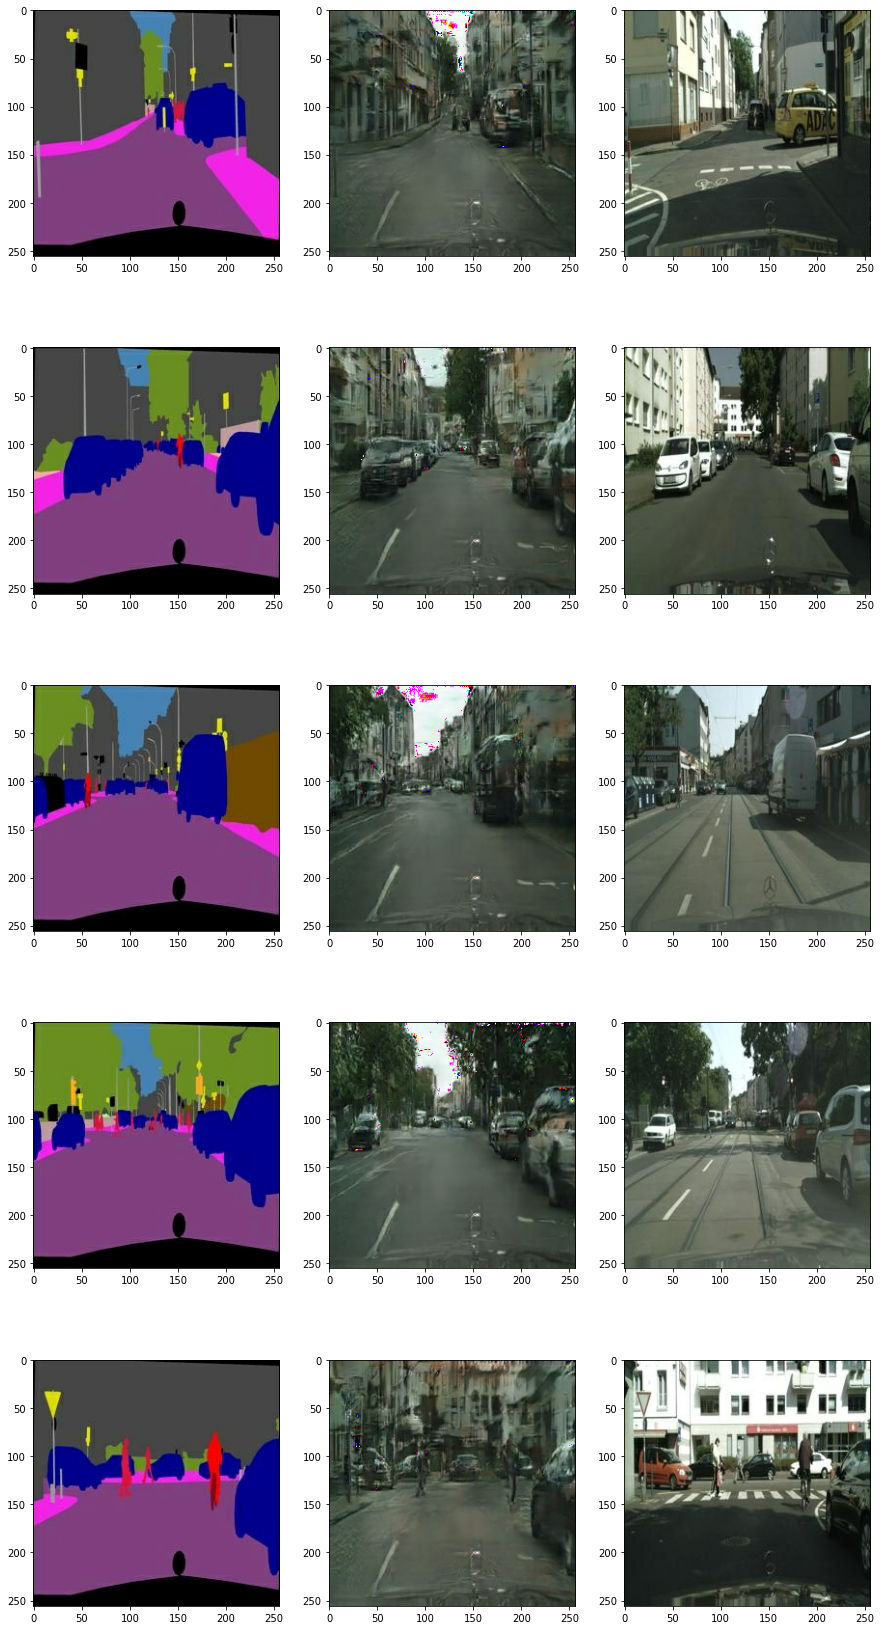

In [20]:
fig, axs = plt.subplots(nrows=5, figsize=(15, 30))

for idx, ax in enumerate(axs):
    f = val_path + os.listdir(val_path)[idx]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.subplot(5, 3, 1+(idx*3)); plt.imshow(denormalize(sketch))
    plt.subplot(5, 3, 2+(idx*3)); plt.imshow(pred[0])
    plt.subplot(5, 3, 3+(idx*3)); plt.imshow(denormalize(colored))

아무리 레이블이 분류되어 있다지만 건물은 다 똑같은 건물, 도로는 다 똑같은 도로가 생성된 것 같습니다. 그래도 실제 사진같은 느낌은 좀 있네요.

128epochs가 너무 과했던 것 같지만 3시간이 아까우니 이대로 하겠습니다. 어차피 예상한 정도의 결과입니다.

- - -
## 마무리하며

데이터셋의 다양성을 추가하는 부분에서 LMS의 내용만으로는 이해가 안갔습니다.

데이터셋의 다양성을 추가하는데 왜 데이터의 크기는 그대로인거죠?

결국은 이리저리 뒤집었을 뿐 다양성은 큰 차이가 없어보이는데요.

그 뿐만 아니라 16-7에서 등장한 `Encode-decode`와 `U-Net`의 차이점을 설명해주는 사진이 16-10에선 다르게 쓰인 것 같습니다.

아무튼 데이터셋의 다양성을 제대로 늘리려면 다양성을 추가한 데이터셋만큼 데이터가 늘어나야한다고 생각해서

기존 1000개의 데이터에 다양성을 추가한 이미지로 1000개 더 추가해 총 2000개의 데이터셋으로 만들어서 학습했습니다.

나머지는 예제 코드를 그대로 가져와 자잘한 코드 정리를 한 것 뿐이네요.

하지만 두 가지 데이터셋을 하나로 병합하는 게 상당히 어려웠습니다. 텐서플로우의 데이터셋 타입을 따라야 했으니까요.

텐서플로우의 데이터셋으로 타입을 변경하기 전에 직접 데이터셋을 리스트에 담아 직접 만드는 방법이 가장 기본적으로 떠올랐지만

뭔가 더 간단한 방법이 있을 것 같아 계속 찾아보니까 텐서플로우 API에서 본 `Dateset.concatenate`를 이용해 해결할 수 있었습니다.

하지만 결과는 1000개로 해도, 2000개로 해도,  
10epochs를 해도, 128epochs를 해도 거기서 거기인 것 같네요.

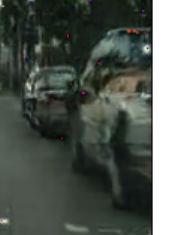

차 안에 차가 그려지는 모습. 차가 비치는 것을 표현한 게 아니라 그냥 픽셀 단위로 의미 분할된 레이블이라

차가 몇 대가 그려져야 할 지 알 수가 없기 때문에 발생한 것 같습니다.

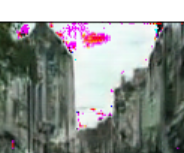

이미지가 깨지는 모습. 주로 하늘 레이블에서 발생합니다.

이유는... 알 수 없네요.